# Toy Example

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/main/docs/src/tutorials/toy_example.ipynb)

In [ ]:
# Skip this cell if you are running the notebook locally and have already installed temporian.
%pip install temporian

In [1]:
import temporian as tp

import pandas as pd
import numpy as np

In [2]:
# Generate a synthetic dataset
timestamps = np.arange(0, 100, 0.1)
n = len(timestamps)
noise = 0.1 * np.random.randn(n)
trend = 0.01 * timestamps
season = 0.4 * np.sin(0.5 * timestamps)

raw_data = pd.DataFrame(
    {
        "timestamp": timestamps,
        # "noise": noise,
        # "trend": trend,
        # "season": season,
        "signal": noise + trend + season,
    }
)

raw_data

,timestamp,signal
0,0.0,0.059995
1,0.1,0.152302
2,0.2,0.024950
3,0.3,0.073056
4,0.4,0.120237
...,...,...
995,99.5,0.627758
996,99.6,0.767645
997,99.7,0.718377
998,99.8,0.967603


In [3]:
# Convert the dataset into a Temporian dataset

source_data = tp.from_pandas(raw_data)

source_data

indexes: []
features: [('signal', float64)]
events:
     (1000 events):
        timestamps: [ 0.   0.1  0.2 ... 99.7 99.8 99.9]
        'signal': [0.06   0.1523 0.0249 ... 0.7184 0.9676 1.0279]

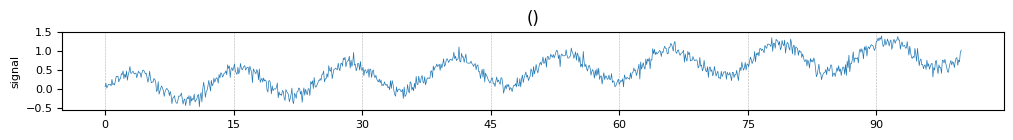

In [4]:
# Plot the dataset
_ = source_data.plot()

In [5]:
# Compute some signals
source = source_data.node()

signal = source["signal"]
trend = tp.simple_moving_average(signal, 50)
detrend = signal - trend
trend2 = tp.simple_moving_average(detrend, 10)
detrend2 = detrend - trend2
slope = trend2 - tp.resample(tp.lag(trend2, 5), trend2)

# TODO: Clean feature names with rename.
result = tp.glue(
    signal,
    tp.prefix("trend.", trend),
    tp.prefix("detrend.", detrend),
    tp.prefix("trend2.", trend2),
    tp.prefix("detrend2.", detrend2),
    tp.prefix("slope.", slope),
)

result_data = tp.evaluate(result, {source: source_data})

result_data

indexes: []
features: [('signal', float64), ('trend.signal', float64), ('detrend.sub_signal_signal', float64), ('trend2.sub_signal_signal', float64), ('detrend2.sub_sub_signal_signal_sub_signal_signal', float64), ('slope.sub_sub_signal_signal_sub_signal_signal', float64)]
events:
     (1000 events):
        timestamps: [ 0.   0.1  0.2 ... 99.7 99.8 99.9]
        'signal': [0.06   0.1523 0.0249 ... 0.7184 0.9676 1.0279]
        'trend.signal': [0.06   0.1061 0.0791 ... 0.7491 0.7501 0.7515]
        'detrend.sub_signal_signal': [ 0.      0.0462 -0.0541 ... -0.0307  0.2175  0.2764]
        'trend2.sub_signal_signal': [ 0.      0.0231 -0.0027 ...  0.2031  0.2016  0.1998]
        'detrend2.sub_sub_signal_signal_sub_signal_signal': [ 0.      0.0231 -0.0515 ... -0.2338  0.0159  0.0766]
        'slope.sub_sub_signal_signal_sub_signal_signal': [    nan     nan     nan ... -0.104  -0.1092 -0.1154]

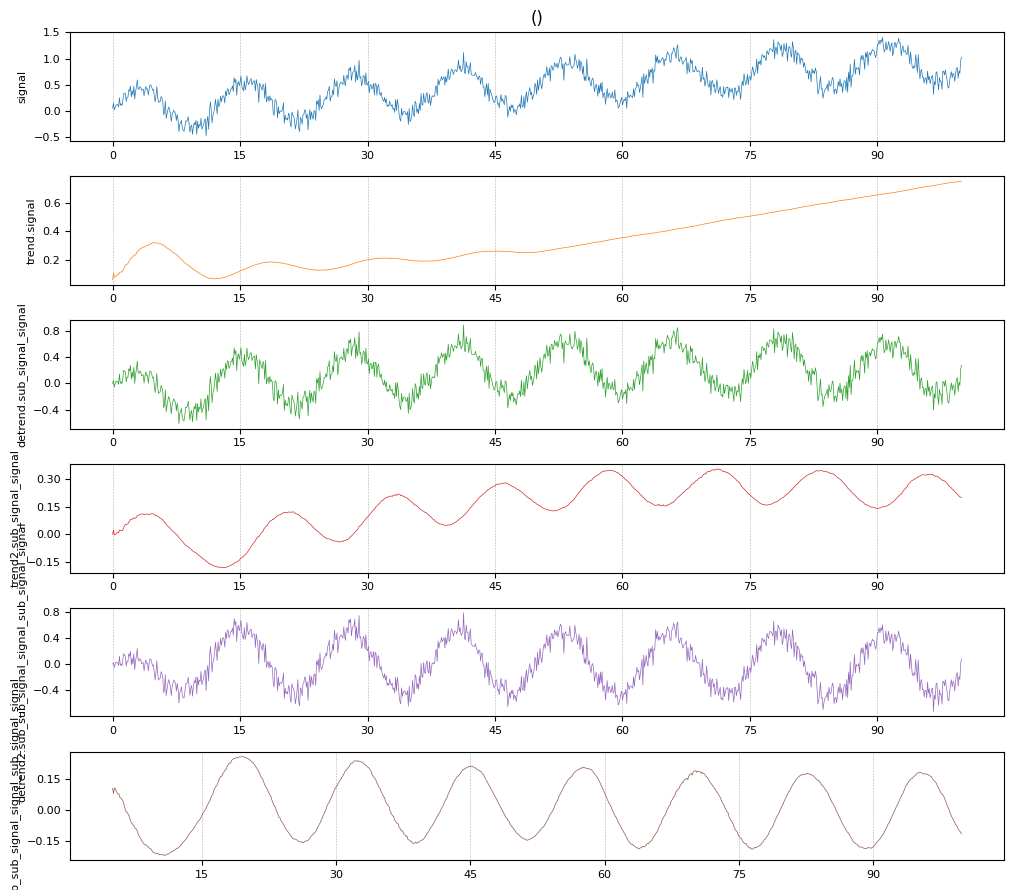

In [6]:
# Plot the results
result_data.plot()